In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing 

In order to represent the intuition that subjects cluster the training cards into groups by disease, a matrix was created to hold training examples for diseases A B and C.

In [3]:
# Data Pre-processing
data = pd.read_csv("Data4.csv")
df = np.array(data)

# Training examples 
print "\nDisease A"
disease_A = df[0:6,0:4]
print disease_A

print "\nDisease B"
disease_B = df[6:12,0:4]
print disease_B

print "\nDisease C"
disease_C = df[12:18,0:4]
print disease_C

# Test examples
df_test = df[21:26,0:3]


Disease A
[['Puffy' 'Flaking' 'Knotty' 'A']
 ['Puffy' 'Sweaty' 'Twitchy' 'A']
 ['Puffy' 'Pallid' 'Limp' 'A']
 ['Sunken' 'Pallid' 'Twitchy' 'A']
 ['Bloodshot' 'Pallid' 'Strained' 'A']
 ['Puffy' 'Blotchy' 'Limp' 'A']]

Disease B
[['Bloodshot' 'Pallid' 'Strained' 'B']
 ['Puffy' 'Blotchy' 'Limp' 'B']
 ['Watery' 'Blotchy' 'Strained' 'B']
 ['Bloodshot' 'Blotchy' 'Strained' 'B']
 ['Sunken' 'Flaking' 'Strained' 'B']
 ['Watery' 'Sweaty' 'Strained' 'B']]

Disease C
[['Cloudy' 'Pallid' 'Twitchy' 'C']
 ['Cloudy' 'Flaking' 'Strained' 'C']
 ['Cloudy' 'Sweaty' 'Knotty' 'C']
 ['Cloudy' 'Pallid' 'Knotty' 'C']
 ['Cloudy' 'Flaking' 'Knotty' 'C']
 ['Bloodshot' 'Sweaty' 'Knotty' 'C']]


# Rule-Exception Cognitive Model

A rule-exception approach was taken to represent the cognitive process of categorization. This model suggests that subjects make logical rules for each disease, and apply these rules to choose a disease category when presented with unseen data. The rules are based on the associated of a dimension value with a disease. For example, a rule could be represented as associating puffy eyes with disease A. The acceptance of a rule is based on how frequent the rule occurs i.e. the probability of the rule showing true. 

A threshold of 0.3 requires that an association is true for 30% or more disease examples for a rule to be created. For example, if Puffy eyes occurs 3 times out of the total 6 examples for disease A, the probability of occurrence is 0.50 and an association rule is stored. 

Exceptions to rules are also modelled. It is theorized that while human categorization processes create logical rules to represent categorical information, exceptions to these rules are also recorded. Only exceptions to ‘dominant’ rules are recorded for the outlined model. The dominant rule is the rule that has the highest probability of occurrence in a disease set. For example, if Puffy eyes is the dominant rule for a disease and occurs 5 out of the total 6 examples, the remaining dimension value is stored with a 1/6 probability of occurrence.

In [11]:
# Threshold for rule acceptance
threshold = 0.3

### Exception Function

In [4]:
def get_exception(rules_array,proba_array,disease_type):
    """Function to find rule exceptions.

    Parameters
    ----------
    rules_array : array of shape = [n_rules, n_dimensions]
                Holds rules associated with a disease.
    proba_array : list of length = n_rules
                Holds the probability the rule holds true
    disease_type : array of shape = [n_disease_examples, n_dimensions]
                Holds the training data for a disease type
    Returns
    -------
    exception_array : array of shape = [n_exceptions, n_dimensions].
                    Exceptions to the most dominant rule.
    exception_proba : list of length = n_exceptions
                    Holds the probability the rule holds true
    """
    # The attribute (column index) associated with the dominant rule
    index = 0
    # The attribute value associated with the dominant rule
    dominant_dimension_val = 0

    exception_proba = []
    exception_array = np.zeros(shape=(1, 3), dtype=str)

    # Find the dominant rule / rule with highest probability of occurring
    highest_proba= proba_array.index(max(proba_array))
    dominant_rule = rules_array[highest_proba]
    # Find dimension and dimension value in this rule
    for i in range(len(dominant_rule)):
        if not dominant_rule[i] == 0:
            dominant_dimension_val = dominant_rule[i]
            index = i
    # Find any examples that are exceptions to this rule
    for i in range(len(disease_type)):
        if not disease_type[i,index] == dominant_dimension_val:
            # Temporarily hold exception
            exception_temp = np.zeros(shape=(1, 3), dtype=basestring)
            # Save the dimension value that is different to the dominant dimension val
            exception_temp[0, index] = disease_type[i,index]
            # Append to final exception list
            exception_array = np.vstack((exception_array, exception_temp))
            # Append probability of exception occurring
            exception_proba.append(len(np.where(disease_type[index]==dominant_dimension_val))/float(len(disease_type)))

    # Remove first dummy row from array
    exception_array = np.delete(exception_array, (0), axis=0)

    return exception_array,exception_proba

### Rule Function

In [14]:
# Count the number each attribute value occurs
def make_rule(disease_type):

    """Function that finds dimension values that occur frequently and makes a rule for each of these values.
    A rule is represented as a row in the the rules array which contains the dimension value in the column
    index of the dimension in the disease array. For example if a rule is created for dimension = Eyes,
    dimension_value = Puffy, the row for the rule will be ['Puffy', 0 , 0 ], because 'Eyes' is the first
    dimension in the disease array

    Parameters
    ----------
    disease_type : array of shape = [n_disease_examples, n_dimensions]
                Holds the training data for a disease type
    Returns
    -------
    rules_array : array of shape = [n_rules, n_dimensions].
                    Rules and exceptions for a disease
    proba_array : list of length = n_rules
                    Probability the rules and exceptions hold true
    """

    rules_array = np.zeros(shape=(1, 3), dtype=str)
    proba_array = []

    """ For each dimension of a disease find dimensions values that have a probability of 
    occurring over the threshold value and make a rule"""
    for j in range(len(rules_array[0])):
        # Count the number of times a dimension value occurs
        unique_elements, counts_elements = np.unique(disease_type[:, j], return_counts=True)
        # divide by the total number of examples to get the probability the value occurs
        dimension_proba = counts_elements / float(len(disease_type))
        values = np.asarray((unique_elements, dimension_proba))

        # Find any dimension values above the threshold
        for i in range(len(values[0])):
            if values[1, i] >= threshold:
                rules_temp = np.zeros(shape=(1, 3), dtype=basestring)
                # Create a rule
                rules_temp[0, j] = values[0, i]
                rules_array = np.vstack((rules_array, rules_temp))
                proba_array.append(values[1, i])

    # Remove first dummy row from array
    rules_array = np.delete(rules_array, (0), axis=0)

    # Get exceptions to the dominant rule
    exceptions, exception_proba = get_exception(rules_array, proba_array,disease_type)
    # Append exceptions to rules array
    rules_array = np.vstack((rules_array, exceptions))
    # Append exceptions probabilities to rules array
    proba_array.extend(exception_proba)

    return rules_array, proba_array

"make_rule" function: Creates rules from observed data. If a rule is true for 30% of the examples for a diseasee, the rule is saved to a rule array. There is one rule array for each disease. 

In [15]:
rules_a,rules_a_proba = make_rule(disease_A)
rules_b,rules_b_proba = make_rule(disease_B)
rules_c,rules_c_proba = make_rule(disease_C)

### Score Function

"get_score" function: Takes in unseen data and searches for rules in the data. The function then scores the example depending on how likley the rule is to occur. This score represents the confidence level that the example belongs to a certain disease, because if a rule has a higher likely hood of holding true the confidence in the rule is higer. For example if a rule states that puffy eyes is associated with diease A and that is true for three out of four of the training examples for disease A then there is 75% confidence that person has disease A if  puffy eyes is an attribute value.

In [17]:
def get_score(rules_array,proba_array,X):

    """Function to find the scores of unseen data.

    Parameters
    ----------
    rules_array : array of shape = [n_rules, n_dimensions]
                Holds rules for associated with a disease.
    proba_array : list of length = n_rules
                Holds the probability the rule holds true
    X : array of shape = [n_test_examples, n_dimensions]
                Test data
    Returns
    -------
    scores : list of length = [n_test_examples].
                Scores given to the likelihood of test data
                resulting in a given disease A, B or C
    """
    scores = np.zeros(shape=( len(X),1))
    for j in range(len(X)):
        temp_score = []

        for i in range(len(X[0])):
            # Find the index where there is a rule for a test example
            itemindex = np.where(rules_array==X[j,i])
            # If there is no rule for an example apply score of zero
            if len(itemindex[0]) ==0:
                temp_score = np.append(temp_score, 0)
            # If a rule applies, score = probability/confidence level of rule occurring
            else:
                index_value = (itemindex[0])[0]
                temp_score =np.append(temp_score,proba_array[index_value])
        scores[j,0] = sum(temp_score)
    return scores

In [18]:
disease_a_score = get_score(rules_a,rules_a_proba,df_test)
disease_b_score = get_score(rules_b,rules_b_proba,df_test)
disease_c_score = get_score(rules_c,rules_c_proba,df_test)
disease_scores = np.column_stack((disease_a_score,disease_b_score,disease_c_score))

### Conjunctive Score Function

In [19]:
def get_conjunctive_score(individual_scores):

    """   Iterate through row and column in the individual_scores array
    and find mean between

    Parameters
    ----------
    individual_scores : array of shape = [n_test_examples, n_diseases].
                Scores given to the likelihood of test data
                resulting in a given disease A, B or C
    Returns
    -------
    scores : array of shape = [n_test_examples, n_disease_conjunctions].
                Scores given to the likelihood of test data
                resulting in a conjunction of given diseases.
                Conjunctions: Diseases A and B, B and C , A and C
    """
    # Initialize array to hold scores
    conjunctive_score = np.zeros(shape=(len(df_test), 3))
    print individual_scores
    # Iterate through row and column in the individual_scores array
    for i in ( range(len(individual_scores[0]-1)) ):
        for j in range(len(individual_scores)):
            # If at the last disease scores, loop back to compare to the first
            if i == len(individual_scores[0])-1:
                values=[individual_scores[j,0],individual_scores[j,-1]]
                conjunctive_score[j,i] = np.mean(values)
            # Otherwise compare current scores to the next disease in the array
            else:
                conjunctive_score[j,i] = np.mean(individual_scores[j,i:i+2])
    return conjunctive_score

In [ ]:
conjunctive_score_array = get_conjunctive_score(disease_scores)
combined_scores = np.column_stack((disease_scores,conjunctive_score_array))

### Z-transform

In [27]:
# Z transforms of peoples scores and models scores
peoples_scores = np.asarray((df[21:51,5]),dtype='float64')
peoples_scores = stats.zscore(peoples_scores)
model_scores = stats.zscore(combined_scores.flatten(order='F'))
z_score_df  = pd.DataFrame({'Peoples_scores':peoples_scores, 'Model_scores':model_scores})

### Pearson Correlation Coefficient 

In [25]:
# Calculate pearson correlation coefficient
correlation = np.corrcoef(model_scores,peoples_scores)
print "Correlation Coefficient: "
print correlation


Correlation Coefficient: 
[[ 1.          0.55939468]
 [ 0.55939468  1.        ]]


### Display Results 

In [39]:
# Display Results in a data frame
disease_names = np.asarray(df[21:51,4])
test_data = np.asarray(df[21:26,3])
test_data = np.tile(test_data, 6)
display = np.column_stack((disease_names,test_data,model_scores,peoples_scores))
headers = ['Disease Category', 'Test Symptoms' ,'Model', 'People']



results_df = pd.DataFrame(display)
results_df.columns = headers

print results_df

      Disease Category               Test Symptoms      Model     People
0           category A       Puffy Blotchy Twitchy    1.24129    2.17236
1           category A      Cloudy Sweaty Strained   -1.77806   -1.55241
2           category A        Sunken Pallid Knotty   0.234839  -0.114294
3           category A    Bloodshot Blotchy Knotty   -1.27484  -0.102734
4           category A  Bloodshot Flaking Strained   -1.27484   0.283385
5           category B       Puffy Blotchy Twitchy  -0.268387   0.142348
6           category B      Cloudy Sweaty Strained   0.738064  -0.139727
7           category B        Sunken Pallid Knotty   -1.77806  -0.616017
8           category B    Bloodshot Blotchy Knotty   0.738064   0.475288
9           category B  Bloodshot Flaking Strained    1.74451    2.22323
10          category C       Puffy Blotchy Twitchy   -1.77806   -1.48999
11          category C      Cloudy Sweaty Strained    1.74451    2.01745
12          category C        Sunken Pallid Knotty 

### Plot Results

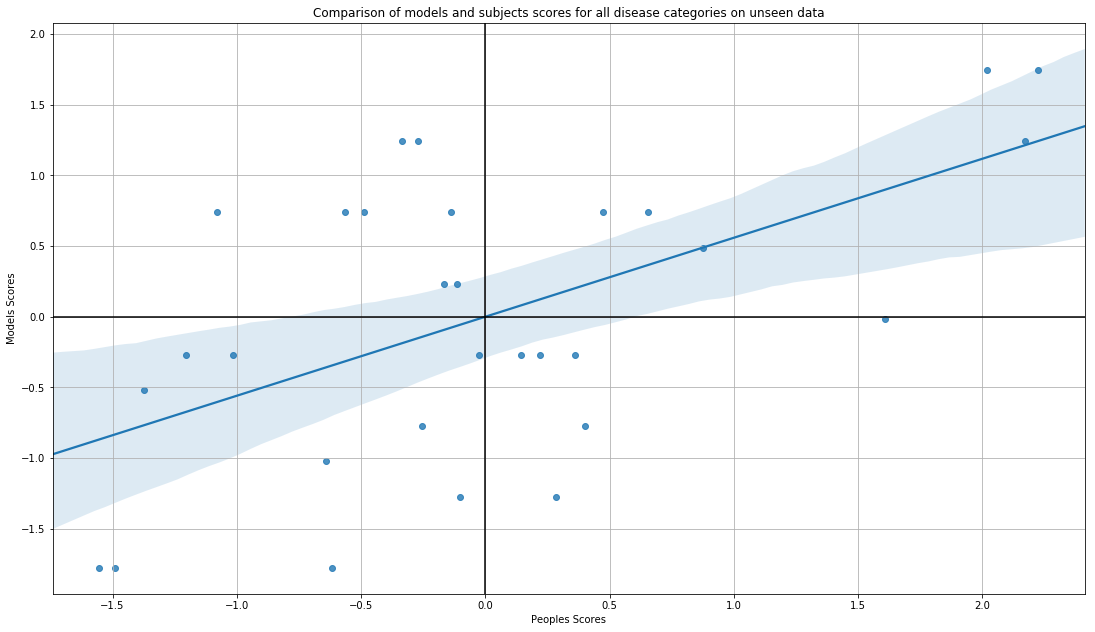

In [26]:
# Plot peoples scores vs models scores with regression line

ls = sns.regplot(x=z_score_df['Peoples_scores'], y=z_score_df['Model_scores'])
ls.figure.set_size_inches(18.5, 10.5)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel('Peoples Scores')
plt.ylabel('Models Scores')
plt.title('Comparison of models and subjects scores for all disease categories on unseen data')
plt.grid()
plt.show()